# Blackjack Simulation

In this notebook, we will attempt to perform Monte Carlo simulations of a player vs. dealer Blackjack contest. We assume that the casino follows the classic rules of Blackjack. We also explore the possibility of the 6 to 5 payoff instead of the tradional 3 to 2. This is known to result in a worse outcome for the player, but to what extent? All this and more in the blocks that follow!

In [357]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

A guide for decision-making in blackjack. This is based on the strategy table provided by : https://www.blackjackapprenticeship.com/how-to-play-blackjack/. 

In [358]:
def PlayerGuide(player_cardset, dealers_pick, surr_allowed=False):

    num_aces = 0
    hard = 0

    for card in player_cardset:
        if card == 1:
            num_aces += 1

    num_player_cards = len(player_cardset)

    for val in player_cardset:
        hard += val
    # If the total hard count is greater than 11, it is best to not consider the ace as an '11' card

    if hard <= 11:
        # The value of the ace is 11 in this case
        soft = hard + 11*num_aces - num_aces
        # To handle the case of two aces
        if soft > 21:
            soft = (hard-1) + 11

    elif hard > 11:
        soft = hard
    # Common conditions based only on the total hard and soft counts

    if hard >= 17:
        return 'Stand'

    if num_player_cards == 2 and soft == 21:
        return 'Blackjack'

    if soft >= 19:
        return 'Stand'

    # When the player has chosen to stand or not yet drawn a card

    if num_player_cards == 2:

        if player_cardset[0] == player_cardset[1]:
            card = player_cardset[0]

            split_conditions = (card == 1) or (card == 8 and dealers_pick != 1) or (card in [2, 3, 7] and dealers_pick not in [1, 8, 9, 10]) or (
                card == 9 and dealers_pick not in [1, 7, 10]) or (card == 6 and dealers_pick not in [1, 7, 8, 9, 10]) or (card == 4 and dealers_pick in [5, 6])
            if split_conditions:
                return 'Split'

            if card == 9 and dealers_pick in [1, 7, 10]:
                return 'Stand'

        if hard == soft:

            if(surr_allowed == False):
                double_conditions = (hard == 11 and dealers_pick != 1) or (hard == 10 and dealers_pick not in [
                    1, 10]) or (hard == 9 and dealers_pick not in ([1, 2, 7, 8, 9, 10]))
                if double_conditions:
                    return 'Double'

                hit_conditions = (hard == 12 and dealers_pick in [1, 2, 3]) or (
                    hard <= 11) or (dealers_pick in [1, 7, 8, 9, 10] and hard < 17)
                if(hit_conditions):
                    return 'Hit'

            return 'Stand'

        if hard != soft:

            double_conditions2 = (soft == 17 and dealers_pick in [3, 4, 5, 6]) or (soft in [
                15, 16] and dealers_pick in [4, 5, 6]) or (soft in [13, 14] and dealers_pick in [5, 6])

            if double_conditions2:
                return 'Double'

            if soft == 18:

                if dealers_pick not in ([1, 2, 7, 8, 9, 10]):
                    return 'Double'

                if dealers_pick in [2, 7, 8]:
                    return 'Stand'

            return 'Hit'

    # After a player has asked for a card

    if num_player_cards > 2:

        if soft <= 17 or (soft == 18 and dealers_pick in [1, 9, 10]):
            return 'Stand'

        if hard == soft:
            if hard <= 11 or (hard == 12 and dealers_pick <= 3) or (dealers_pick in [1, 7, 8, 9, 10]):
                return 'Hit'
            return 'Stand'

Simulating a single blackjack round. 
Code references: 

https://towardsdatascience.com/python-blackjack-simulator-61b591ffb971

https://github.com/molron94/Blackjack-Sim

Note: These are references only. The setting and the idea of what a single round should constitute is inspired from the links above. The rules and payouts remain the same for each round.

In [378]:
def blackjack_round(bet_amount=10, player_cardset='no_initial_condition', dealer_stay_num = 17, single_dealer_card='no_initial_condition', payback_type = "3to2", deck = [1,2,3,4,5,6,7,8,9,10,10,10,10]*24):
    
    def end_round():
        card_list=[1,2,3,4,5,6,7,8,9,10,10,10,10]*4
        num_decks = 6
        deck = card_list*num_decks
        return deck
    
    if (deck == [1,2,3,4,5,6,7,8,9,10,10,10,10]*24):
        card_list=[1,2,3,4,5,6,7,8,9,10,10,10,10]*4
        num_decks = 6
        deck = card_list*num_decks
    
    stand = False
    
  
    if player_cardset == 'no_initial_condition':
        ch1 = np.random.choice(deck, replace=False)
        deck.remove(ch1)
        ch2 = np.random.choice(deck, replace=False)
        deck.remove(ch2)
        player_cardset=[ch1, ch2]
        
        
    if single_dealer_card == 'no_initial_condition':
        dealer_cardset = []
        ch = np.random.choice(deck, replace=False)
        single_dealer_card = ch
        deck.remove(ch)
        
        dealer_cardset.append(single_dealer_card)
        
        
    while len(player_cardset) < 2:
        
        ch = np.random.choice(deck, replace=False)
        player_cardset.append(ch)
        deck.remove(ch)

    
    # Check if a blackjack has been scored
    if PlayerGuide(player_cardset, single_dealer_card) == 'Blackjack':
            
            # Has the casino also scored a blackjack?
            dealer_cardset.append(np.random.choice(deck, replace=False))
            if 1 in (dealer_cardset):
                if sum(dealer_cardset)==11:
                    deck = end_round()
                    return 0
            else :
                if(payback_type == "3to2"):
                    deck = end_round()
                    return bet_amount*1.5

                elif(payback_type == "6to5"):
                    deck = end_round()
                    return bet_amount*6/5
                
    if PlayerGuide(player_cardset, single_dealer_card) == 'Stand':
            stand = True
    
        
    if stand == False:
        
        
        if PlayerGuide(player_cardset, single_dealer_card) == 'Hit':
            ch = np.random.choice(deck, replace=False)
            player_cardset.append(ch)
            deck.remove(ch)
            
            if sum(player_cardset)>21:
                deck = end_round()
                return 0 - bet_amount

           
        if PlayerGuide(player_cardset, single_dealer_card)== 'Split':
            
            new_turn = blackjack_round(bet_amount, [player_cardset[0]], single_dealer_card, deck = deck) 
            new_turn += blackjack_round(bet_amount, [player_cardset[1]], single_dealer_card, deck = deck)

            return new_turn
        
        if PlayerGuide(player_cardset, single_dealer_card)=='Double':
            
            ch = np.random.choice(deck, replace=False)
            player_cardset.append(ch)
            deck.remove(ch)
            bet_amount= bet_amount * 2
            if sum(player_cardset)>21:
                deck = end_round()
                return 0- bet_amount

            
    while True:
        
        ch = np.random.choice(deck, replace=False)
        dealer_cardset.append(ch)
        deck.remove(ch)
        
        # Compute the dealer's score and the player's score - represented by d_score and p_score
        d_score= sum(dealer_cardset)
        p_score=sum(player_cardset)
        if p_score<=11 and 1 in player_cardset:
            p_score+=10

        dealer_soft_score= d_score
        if d_score<=11 and 1 in dealer_cardset:
            dealer_soft_score+=10

        # Dealer scores a blackjack!
        if len(dealer_cardset)==2 and dealer_soft_score==21:
            return 0-bet_amount

        # Conditions to win or lose money
        # We'll assume that this is a traditional casino where the dealer cannot hit when on a soft 17. This can be changed in the function parameters.
        if dealer_soft_score>=dealer_stay_num:

            if dealer_soft_score>21:
                return bet_amount

            if p_score==dealer_soft_score:
                return 0
            
            if p_score>dealer_soft_score:
                return bet_amount
            
            if p_score<dealer_soft_score:
                return 0 - bet_amount
            
                

 

In [379]:
import pandas as pd

def compute_stats(sim):
    
    condition = sim[0]
    num_runs = sim[2]
    k = sim[1]
    bet = sim[3]
    
    
    ax = sns.kdeplot(k)
    ax.set(xlabel='Distribution of Wins and Losses', ylabel='Frequency')
    
    
    zero_count = 0
    positive_count = 0
    blackjacks = 0
    negative_count = 0

    for ele in k:
        if ele == 0:
            zero_count += 1
        elif ele > 0:
            positive_count += 1
        elif ele < 0:
            negative_count += 1

        if ele > bet and ele < bet*2:
            blackjacks += 1

    results = {'Number of Zero Transactions' : [zero_count], 
               "Number of Positive Results (Including Blackjacks)" : [positive_count],
               "Number of Negative Results" : [negative_count],
               "Number of Blackjacks" : [blackjacks]
              }
    
    print("Mean of winnings for each round = {}".format(np.mean(k)))
    print("Variance of winnings = {}".format(np.std(k)**2))
    print ("Total bet: " + str(bet * num_runs))
    print ("Net amount gained or lost by the player: " + str(np.mean(k)*num_runs))
    
    print("Loss or Gain percentage: " + str((np.mean(k)*num_runs)*100/(bet * num_runs)) + "%")
    
    print()
    print("95% Confidence interval:")
    
    conf_int = (np.mean(k) - 1.96*(np.sqrt(np.std(k)/num_runs)), np.mean(k) + 1.96*(np.sqrt(np.std(k)/num_runs)))
    print(conf_int)
    
    display(pd.DataFrame.from_dict(results))
    
    
def blackjack_sim(init_hand='no_initial_condition', dealer_stay_num = 17, init_dealer='no_initial_condition', bet=10, payback_type = "6to5", num_runs=100000):
    sim_out=[]
    
    for i in range(num_runs):
        sim_out.append(blackjack_round(bet_amount=bet, dealer_stay_num = dealer_stay_num, player_cardset=init_hand, single_dealer_card=init_dealer, payback_type = payback_type))
    return (init_hand, np.array(sim_out), num_runs, bet)

Running 100,000 rounds and examining the statistics:

Mean of winnings for each round = -0.257
Variance of winnings = 526.183951
Total bet: 200000
Net amount gained or lost by the player: -2570.0
Loss or Gain percentage: -1.285%

95% Confidence interval:
(-0.3508729510347921, -0.16312704896520794)


,Number of Zero Transactions,Number of Positive Results (Including Blackjacks),Number of Negative Results,Number of Blackjacks
0,780,4351,4869,411


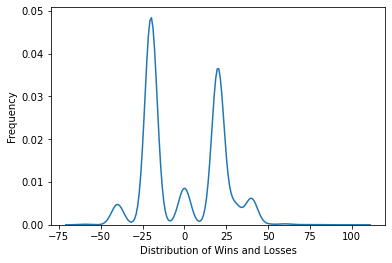

In [380]:
sim = blackjack_sim(num_runs=10000, bet=20, payback_type = "3to2")
compute_stats(sim)

How much worse does a 6 to 5 payoff make it for the player?

Mean of winnings for each round = -0.55716
Variance of winnings = 504.84613273439993
Total bet: 2000000
Net amount gained or lost by the player: -55716.0
Loss or Gain percentage: -2.7858%

95% Confidence interval:
(-0.5865395966974034, -0.5277804033025966)


,Number of Zero Transactions,Number of Positive Results (Including Blackjacks),Number of Negative Results,Number of Blackjacks
0,8267,42879,48854,4032


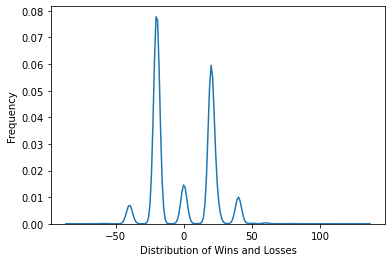

In [362]:
sim2 = blackjack_sim(num_runs=100000, bet=20, payback_type = "6to5")
compute_stats(sim2)

The block below shows how crucial it is for the dealer to stay at 17. Staying at 19 instead of 17 causes the player to start beating the casino quite convincingly as shown below:

Mean of winnings for each round = 2.1528
Variance of winnings = 516.2246521599999
Total bet: 200000
Net amount gained or lost by the player: 21528.0
Loss or Gain percentage: 10.764%

95% Confidence interval:
(2.059374429951673, 2.246225570048327)


,Number of Zero Transactions,Number of Positive Results (Including Blackjacks),Number of Negative Results,Number of Blackjacks
0,610,5001,4389,420


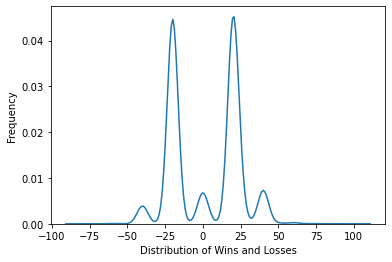

In [363]:
sim3 = blackjack_sim(num_runs=10000, bet=20, payback_type = "6to5", dealer_stay_num = 19)
compute_stats(sim3)

Here, the player makes a tidy profit of about 10.76%. The kernel density plot also shows how the positive peak is slightly higher then the negative peak. With the added advantage of a blackjack payoff, the player can eventually beat the casino and make money.